# Creating Digitally Reconstructed Radiographs (DRRs) using `DiffDRR`:
---

### Creating DRR and rendering 2D visualizations

In [2]:
# Import libraries
import sys

sys.path.append("..")

from src.preprocessing import get_transforms, get_datasets, get_dataloaders

import torch
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

from diffdrr.drr import DRR
from diffdrr.visualization import plot_drr, plot_mask
from diffdrr.data import read

from diffdrr.pose import convert
from diffdrr.visualization import drr_to_mesh, img_to_mesh
import pyvista

# Set the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [6]:
# Get transforms
transform = get_transforms(resize_shape=[512, 512, 96],contrast_value=1000)

# Get datasets
train_ds, val_ds = get_datasets(
    root_dir="../data",
    collection="HCC-TACE-Seg",
    transform=transform,
    download_len=1,
    val_frac=0.0,
    download=False
)

# Get dataloaders
train_loader, val_loader = get_dataloaders(train_ds, val_ds, batch_size=1)

# Get datalists
train_dl = train_ds.datalist
val_dl = val_ds.datalist

# Check length of datasets, dataloaders and datalists
print(train_ds.get_indices(), val_ds.get_indices())

[0] []


In [7]:
# Sample a batch of data from the dataloader
batch = next(iter(train_loader))

# Separate the image and segmentation from the batch
image, seg = batch["image"], batch["seg"]

print(image.shape, seg.shape)
print(image.dtype, seg.dtype)

torch.Size([1, 1, 512, 512, 96]) torch.Size([1, 1, 512, 512, 96])
torch.float32 torch.float32


In [8]:
labels = [0, 1, 2, 3, 4]

# structures = ["Liver", "Mass", "Portal vein", "Abdominal aorta", "Background"]
# labels = subject.structures.query(f"group in {structures}")["id"].tolist()

# Read in CT volume and label map
subject = read(tensor=image[0], label_tensor=seg[0], orientation="AP", bone_attenuation_multiplier=5)

In [10]:
from src.drr import create_drr

img = create_drr(
    volume=image[0],
    segmentation=seg[0],
    sdd=1020,
    height=200,
    width=200,
    delx=2.0,
    dely=2.0,
    x0=0,
    y0=0,
    reverse_x_axis=True,
    patch_size=None,
    renderer="siddon",
    rotations=torch.tensor([[0.0, 0.0, 0.0]]),
)

In [11]:
print(img.shape)

torch.Size([1, 2, 200, 200])


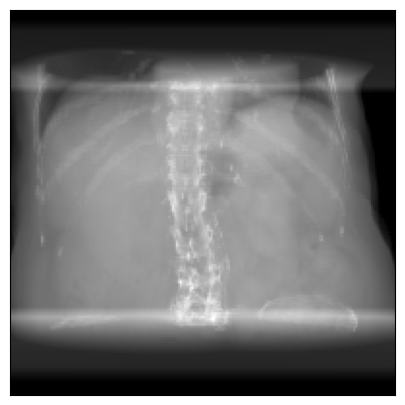

In [12]:
im = img.sum(dim=1, keepdim=True)
drr_image = plot_drr(im, ticks=False)

In [9]:
# Or read in CT volume and label map from datalist path
subject_path = read(
    filename=train_dl[0]["image"],
    orientation="AP",
    bone_attenuation_multiplier=5,
)

In [10]:
# Create a DRR object
drr = DRR(
    subject,  # A torchio.Subject object storing the CT volume, origin, and voxel spacing
    sdd=1020,  # Source-to-detector distance (i.e., the C-arm's focal length)
    height=200,  # Height of the DRR (if width is not seperately provided, the generated image is square)
    width=200,  # Width of the DRR
    delx=2.0,  # Pixel spacing (in mm)
    dely=2.0,  # Pixel spacing (in mm)
    x0=0,  # # Principal point X-offset
    y0=0,  # Principal point Y-offset
    p_subsample = None,  # Proportion of pixels to randomly subsample
    reshape = True,  # Return DRR with shape (b, 1, h, w)
    reverse_x_axis = True,  # If True, obey radiologic convention (e.g., heart on right)
    patch_size = None,  # Render patches of the DRR in series
    renderer = "siddon",  # Rendering backend, either "siddon" or "trilinear"
).to(device)

tensor([[0.3491, 0.0000, 0.0000]], device='cuda:0')
RigidTransform()


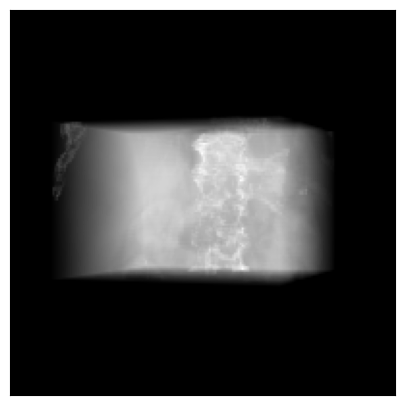

In [11]:
# Set the camera pose with rotations (yaw, pitch, roll) and translations (x, y, z)

zero = torch.tensor([[0.0, 0.0, 0.0]], device=device)
translations = torch.tensor([[0.0, 800.0, 0.0]], device=device)
#rotations = torch.tensor([[torch.pi / 2, torch.pi / 6, 0.0]], device=device)
rotations = torch.tensor([[20.0, 0.0, 0.0]], device=device)
rotations = torch.deg2rad(rotations)
print(rotations)
pose1 = convert(zero, translations, parameterization="euler_angles", convention="ZXY")
pose2 = convert(rotations, zero, parameterization="euler_angles", convention="ZXY")
pose = pose1.compose(pose2)
print(pose)

img = drr(pose, mask_to_channels = True)

im = img.sum(dim=1, keepdim=True)
plot_drr(im, ticks=False)
plt.show()

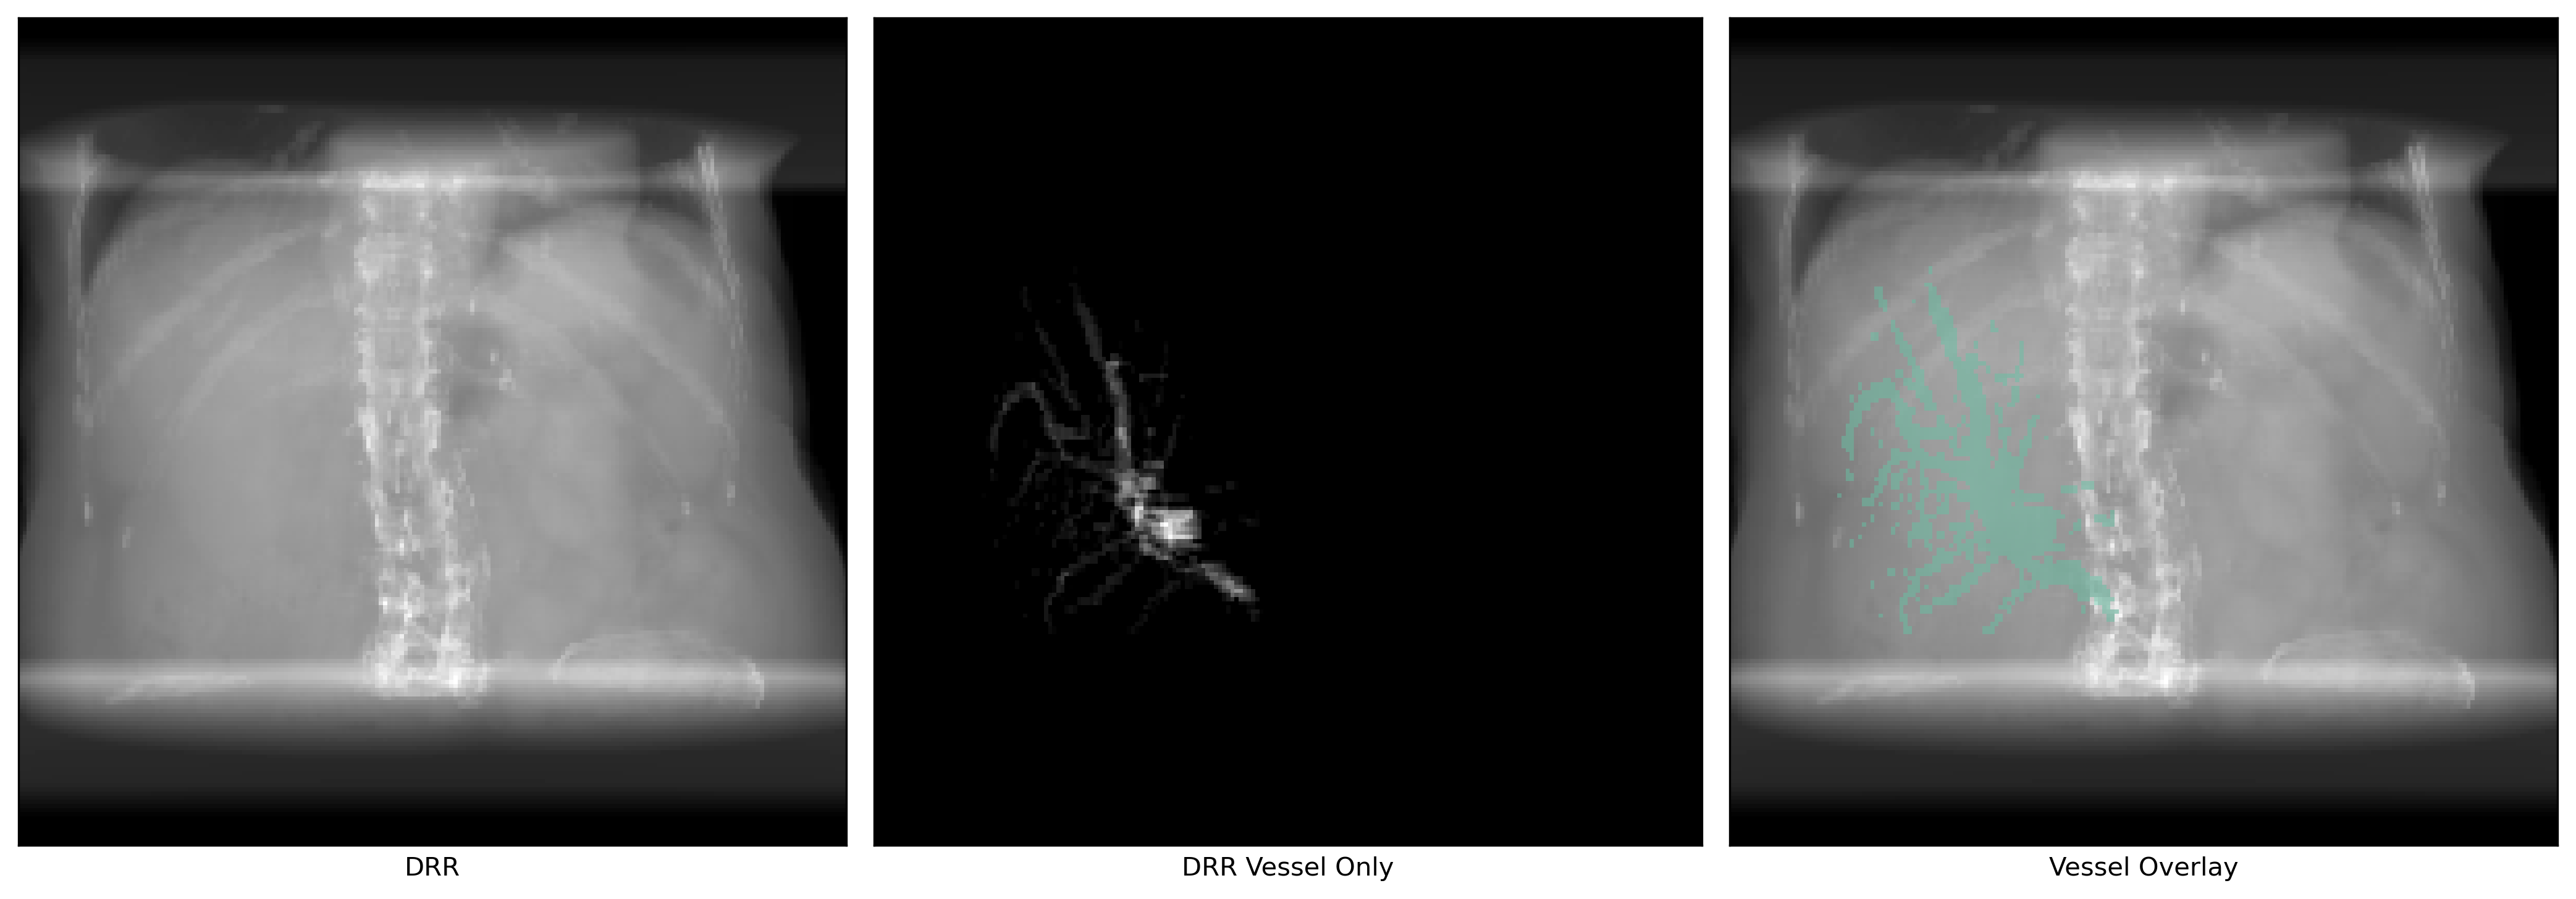

In [13]:
labels = ["Liver"]

# Plot the segmentation masks
fig, axs = plt.subplots(
    nrows=1,
    ncols=3,
    figsize=(14, 7.75),
    tight_layout=True,
    dpi=300,
)

im = img.sum(dim=1, keepdim=True)
plot_drr(im, axs=axs[0], ticks=False, title="DRR")
plot_drr(
    img[:, 1, :, :].unsqueeze(dim=1), axs=axs[1], ticks=False, title="DRR Vessel Only"
)
plot_drr(im, axs=axs[2], ticks=False, title="Vessel Overlay")

for idx, label in enumerate(labels):
    mask = img[:, 1, :, :].unsqueeze(dim=1)
    vessel_mask = plot_mask(mask, axs=axs[2], alpha=0.5, return_masks=True)

### Creating 3D mesh renders and 3D to 2D projections:

In [14]:
# Make a mesh from the CT volume
ct = drr_to_mesh(subject, "surface_nets", threshold=225, verbose=True)

Performing Labeled Surface Extraction: 100%|██████████[00:00<00:00]
Finding and Labeling Connected Regions.: 100%|██████████[00:00<00:00]
Smoothing Mesh using Taubin Smoothing: 100%|██████████[00:00<00:00]
Filling Holes: 100%|██████████[00:00<00:00]
Cleaning: 100%|██████████[00:00<00:00]


tensor([[1.5708, 0.5236, 0.0000]], device='cuda:0')
RigidTransform()


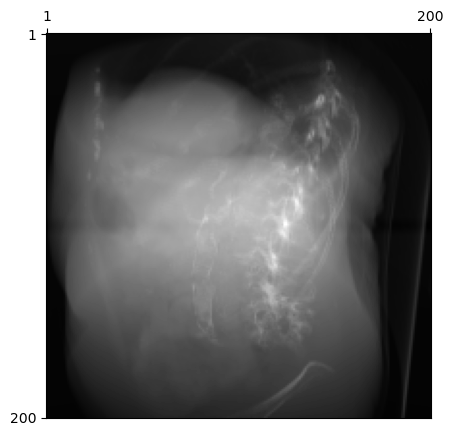

In [15]:
# Initialize the DRR module for generating synthetic X-rays
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
drr = DRR(subject, sdd=1020.0, height=200, delx=2.0).to(device)

# Make a pose
zero = torch.tensor([[0.0, 0.0, 0.0]], device=device)
xyz = torch.tensor([[0.0, 800.0, 0.0]], device=device)
rot = torch.tensor([[torch.pi / 2, torch.pi / 6, 0.0]], device=device)
print(rot)
pose1 = convert(zero, xyz, parameterization="euler_angles", convention="ZXY")
pose2 = convert(rot, zero, parameterization="euler_angles", convention="ZXY")
pose = pose1.compose(pose2)
print(pose)

plot_drr(drr(pose))
plt.show()

In [16]:
# Make a mesh from the camera and detector plane
camera, detector, texture, principal_ray = img_to_mesh(drr, pose)

# Make the plot
plotter = pyvista.Plotter()
plotter.add_mesh(ct)
plotter.add_mesh(camera, show_edges=True, line_width=1.5)
plotter.add_mesh(principal_ray, color="lime", line_width=3)
plotter.add_mesh(detector, texture=texture)

# Render the plot
plotter.add_axes()
plotter.add_bounding_box()

plotter.show()  # If running Jupyter locally
# plotter.show(jupyter_backend="server")  # If running Jupyter remotely
# plotter.export_html("render.html")

Widget(value='<iframe src="http://localhost:59896/index.html?ui=P_0x167afba4650_0&reconnect=auto" class="pyvis…

### Registrating random X-ray pose to reference:

In [18]:
from diffdrr.pose import convert


def pose_from_carm(sid, tx, ty, alpha, beta, gamma):
    rot = torch.tensor([[alpha, beta, gamma]])
    xyz = torch.tensor([[tx, sid, ty]])
    return _pose_from_carm(rot, xyz)


def _pose_from_carm(rot, xyz):
    zero = torch.tensor([[0.0, 0.0, 0.0]]).to(rot)
    R = convert(
        rot,
        zero,
        parameterization="euler_angles",
        convention="ZXY",
    )
    t = convert(
        zero,
        xyz,
        parameterization="euler_angles",
        convention="ZXY",
    )
    return t.compose(R)


gt_pose = _pose_from_carm(rotations, translations)